In [ ]:
# Original Code: https://nbviewer.org/github/flothesof/posts/blob/master/20160803_Autostereograms.ipynb
# Modified to enhance the accessibility of the autostereograms.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import skimage, skimage.io
%matplotlib inline

In [6]:
plt.rcParams['figure.dpi'] = 150

In [63]:
def display(img, colorbar=False):
    "Displays an image."
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = skimage.io.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()

In [64]:
def make_pattern(shape=(16, 16), levels=64):
    "Creates a pattern from gray values."
    return np.random.randint(0, levels - 1, shape) / levels

In [87]:
# Altered to make a pattern with high color contrast
def make_pattern(shape=(16, 16), colors=3, colorbar=True):
    "Creates a pattern using only blue, black, white, and red."
    # Map numbers to specific colors:
    # 0: black, 1: Green, 2: white
    pattern_indices = np.random.randint(0, colors, shape)
    color_map = np.array([[0, 0, 0],      # Black
                          [0, 255, 0],    # Green
                          [255, 255, 255] # White
                         ])
    # Apply the color map to the pattern indices
    return color_map[pattern_indices] 

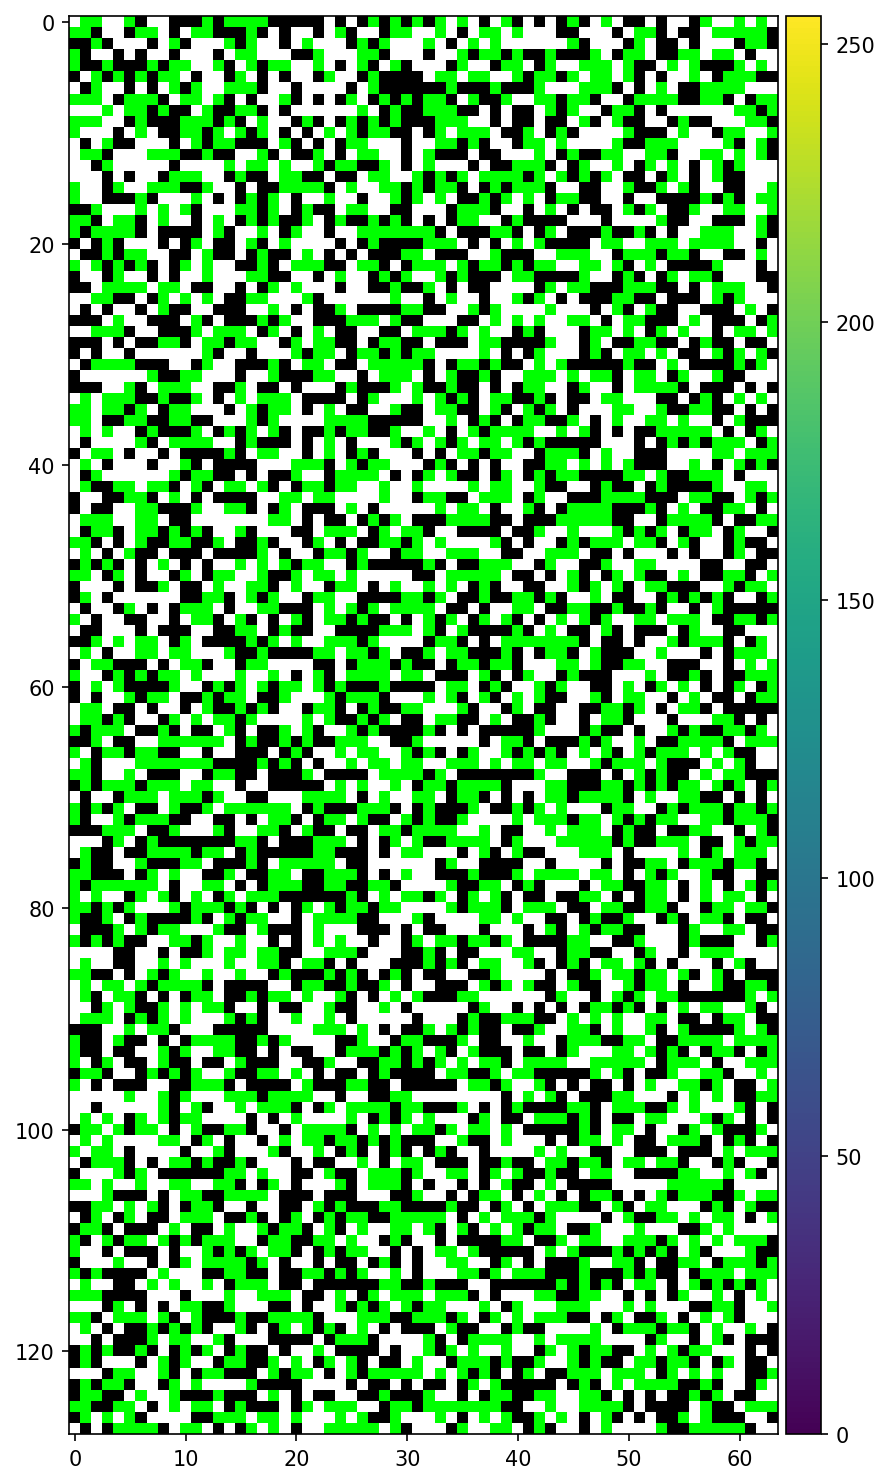

In [88]:
pattern = make_pattern(shape=(128, 64))
display(pattern)

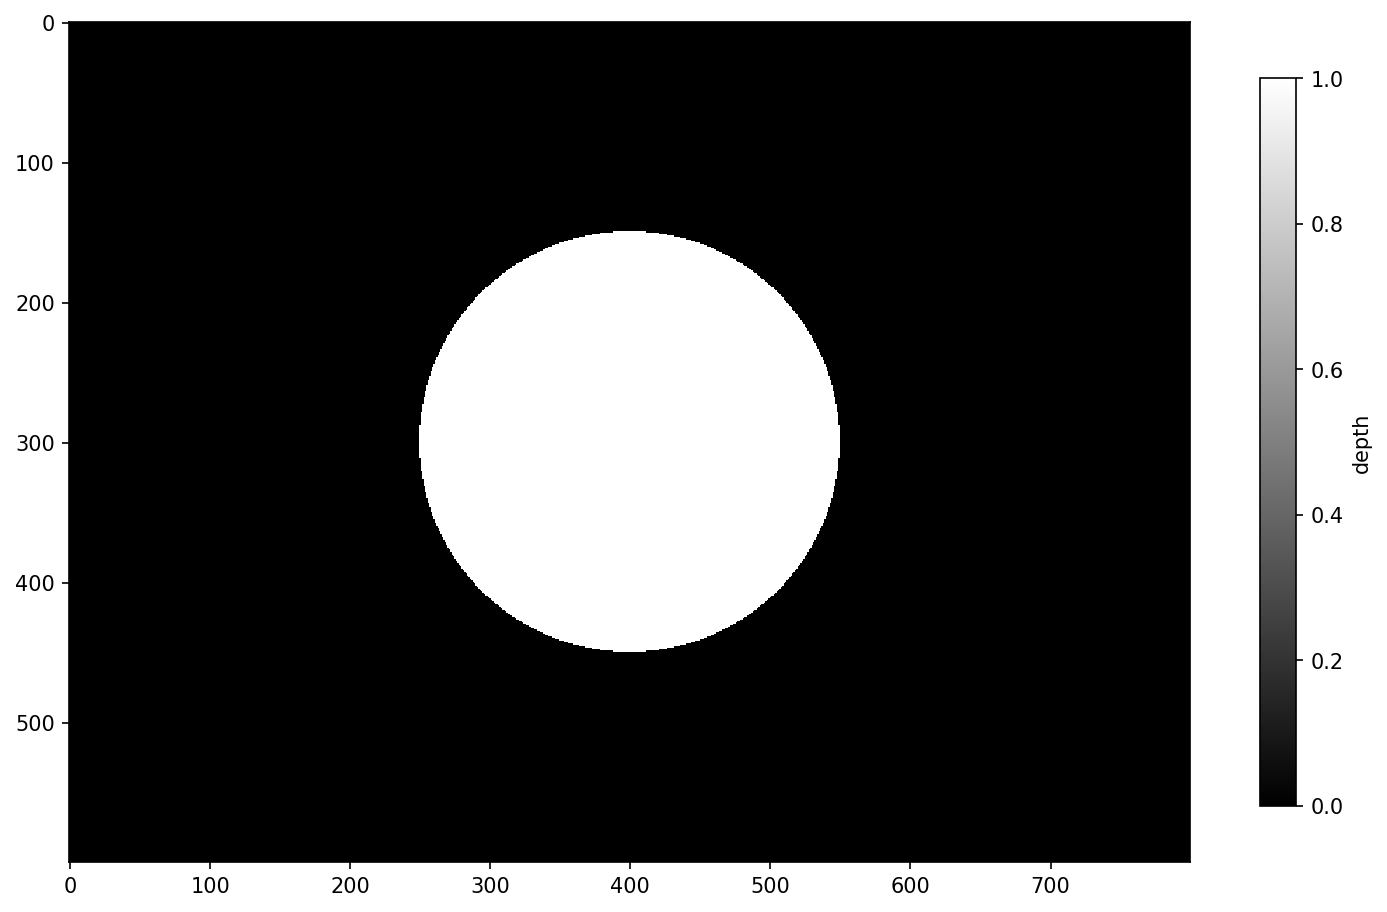

In [93]:
def create_circular_depthmap(shape=(600, 800), center=None, radius=100):
    "Creates a circular depthmap, centered on the image."
    depthmap = np.zeros(shape, dtype=float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap    
depthmap = create_circular_depthmap(radius=150)
display(depthmap, colorbar=True)

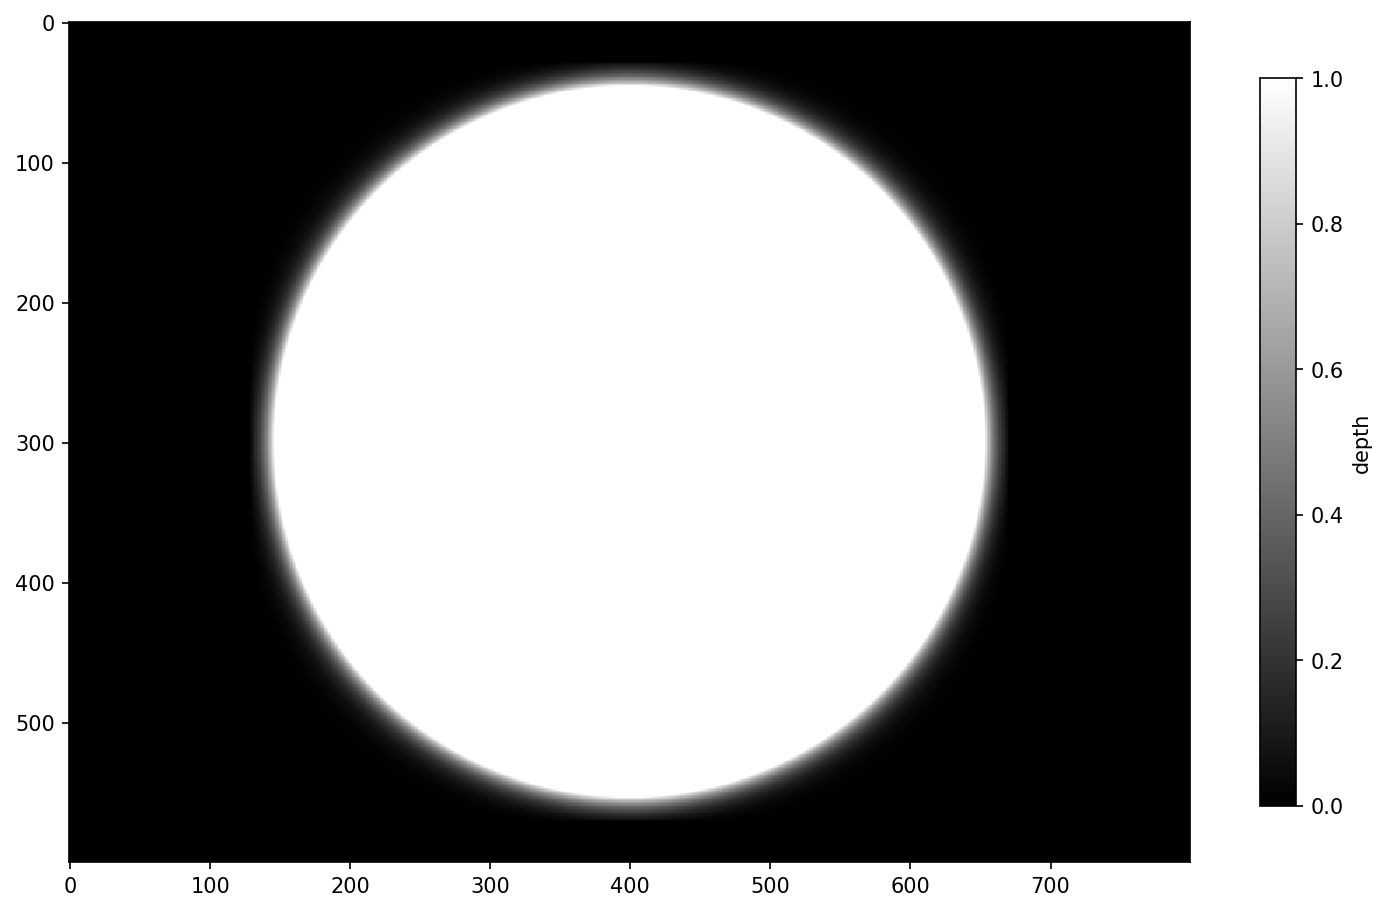

In [106]:
import numpy as np
from scipy.ndimage import gaussian_filter, sobel

def reinforce_edges(depthmap, sigma=30, edge_enhance=500):
    "Enhances the edges in a depth map by applying edge detection and reinforcement."
    # Modified Online Code
    smooth_depthmap = gaussian_filter(depthmap, sigma=sigma)
    
    # Calculate gradients using the Sobel operator
    grad_x = sobel(smooth_depthmap, axis=0)
    grad_y = sobel(smooth_depthmap, axis=1)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize the gradient magnitude to [0, 1]
    max_grad = np.max(gradient_magnitude)
    if max_grad > 0:
        gradient_magnitude /= max_grad
    
    # Enhance the original depth map by adding the scaled gradients
    enhanced_depthmap = depthmap + edge_enhance * gradient_magnitude
    
    # Ensure the enhanced depth map does not exceed the original value range
    enhanced_depthmap = np.clip(enhanced_depthmap, 0, 1)
    
    return enhanced_depthmap

depthmap = create_circular_depthmap(radius=150)  # Assuming you already have this function defined
reinforced_depthmap = reinforce_edges(depthmap)
display(reinforced_depthmap, colorbar=True)

In [90]:
def normalize(depthmap):
    "Normalizes values of depthmap to [0, 1] range."
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

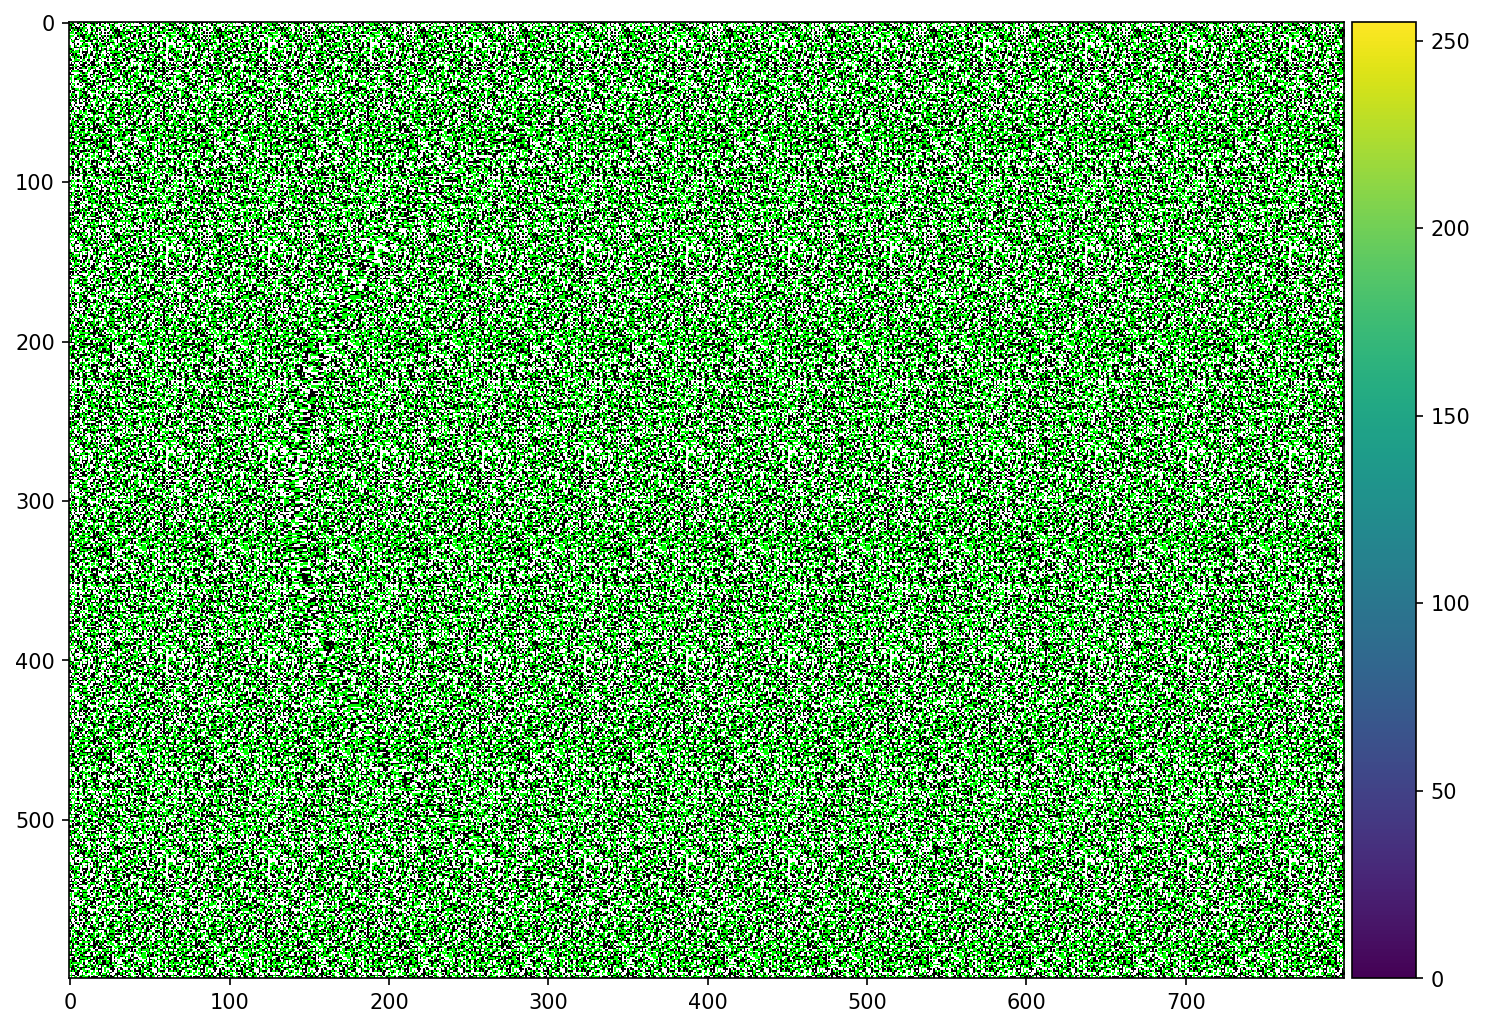

In [107]:
def make_autostereogram(depthmap, pattern, shift_amplitude=0.1, invert=False):
    "Creates an autostereogram from depthmap and pattern."
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros((depthmap.shape[0], depthmap.shape[1], 3), dtype=pattern.dtype)
    pattern_width = pattern.shape[1]
    for r in range(autostereogram.shape[0]):
        for c in range(autostereogram.shape[1]):
            shift = int(depthmap[r, c] * shift_amplitude * pattern_width)
            if c < shift:
                autostereogram[r, c] = pattern[r % pattern.shape[0], 0]
            else:
                autostereogram[r, c] = pattern[r % pattern.shape[0], (c - shift) % pattern_width]
    return autostereogram
autostereogram = make_autostereogram(reinforced_depthmap, pattern)
display(autostereogram)